In [2]:
import time
import importlib
import sys
import pickle
import pandas as pd
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import norm
from scipy import stats
import torch 
import matplotlib.colors as mcolors

import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

vcol =['rosybrown','red','darkseagreen','orange','blueviolet','lawngreen','fuchsia','cyan','darkolivegreen','black','deepskyblue','lightslategray','darkslateblue','sienna','darkgoldenrod','olive']
list_color=['b','g','r','c','m','y']

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 34})
import sys
import scipy
import os
PATH = '../codes/'
sys.path.insert(1,PATH)
import IAE_CNN_TORCH_Oct2023 as cnn
from general import normalize,normalize4, divergence, NNPU, list_array, NMF_divergence, index_array_3D, NMF_fixed_a

from read_data import *
from data_ML import *
from CNN_classification_regression import *

In [3]:

import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing
from enum import Enum 
import copy
from pytorch_lightning import LightningModule, Trainer
import pytorch_lightning as pl
from torchmetrics import Accuracy
from torch.autograd import Variable
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

from torchmetrics import ConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix

In [4]:
# save figure
PATH=""
name_fig_sup='_exp1'

# Load data

In [5]:
RN_NAME=np.array(['Co60', 'Ba133', 'Co57','Cs137','Eu152','Am241','I123','I131','Tc99m'])
RN_NAME_plot=np.array(['Co-60', 'Ba-133', 'Co-57','Cs-137','Eu-152','Am-241','I-123','I-131','Tc-99m'])
# max channel for each radionuclide, Co60: 2*800+20
max_channel_list=np.array([800,250,100,400,900,50,100,500,100])

### Natural Bkg 

In [6]:
Bkg=read_spectrum('../data/SPS_NaITl_3pouces_Exp_1keVCanal_Max2200keV_#20012023A.txt')
Bkg=Bkg[20:2048+20]
Bkg=Bkg[0::2]+Bkg[1::2]
Bkg=Bkg[:]
## avoid zeros for Bkg
Bkg[:2]=1/10*min(Bkg[2:])
XBkg=Bkg/np.sum(Bkg)
XBkg=XBkg[:,np.newaxis]


### Spectral singatures with variability

In [7]:
spec_list=[]
for name in range((len(RN_NAME))):
    spec,list_thickness=GetSpectra(name,RN_NAME,max_channel_list=max_channel_list)
    spec=normalize(spec,opt='1')
    spec_list+=[spec]
spec_list=np.swapaxes(spec_list,0,1)
spec_list=np.swapaxes(spec_list,1,2)


### Spectral drift

In [8]:
with open('../data/data_drift', "rb") as fp:   #Pickling
    spec_all_drift2=pickle.load(fp)

# spectral signatures of all radio
spec_all_drift=spec_all_drift2[:,:,:,1:]
# XBkg 
XBkg_drift=spec_all_drift2[:,:,:,0]
XBkg_drift=np.swapaxes(XBkg_drift,1,2)

In [9]:
# shift factor
list_alpha=np.arange(-0.1,0.11,0.01)
list_alpha=np.round(list_alpha,2)

In [10]:
# shift function
def func_temp(x,alpha):
    return x*(1-alpha[0])+alpha[1]

# Define desired case (1,2 or 3)

In [11]:
variability=True # with variability
drift=False # with spectral drift
withI131=False # with I131 or not (for spectral variability), with I131: problem is more complicated since X of I131 is similar to Ba133
batch_size=512
FPR=0.01 # expected false positive rate


In [12]:
load_pretrained_model=True ##  set false  to train a new CNN model

In [13]:
max_channel_list=np.array([800,250,100,400,900,50,100,500,100])
# wo variability
if variability==False:
    mask=[0,1,2,3,4,5,6,7,8] # mask for radionuclides, use all radionuclides
    RN_NAME2=RN_NAME[mask]
    RN_NAME_plot2=RN_NAME_plot[mask]
    # scenario 1
    if drift==False:
        file_name='../data/Data_spectra_gamma_200000_wo_variability'
        path_checkpoint_multi='lightning_logs/CNN_multi_wo_var_drift.ckpt'
        path_checkpoint_mono=['lightning_logs/'+RN_NAME2[i]+'_CNN_mono_wo_var_drift.ckpt' for i in range(len(RN_NAME2))]
        path_res_unmmixing='../data/resultat_pomp'
    # scenarios 3
    else:
        file_name='../data/Data_spectra_gamma_200000_wo_variability_drift'
        path_checkpoint_multi='lightning_logs/CNN_multi_drift.ckpt'
        path_checkpoint_mono=['lightning_logs/'+RN_NAME2[i]+'_CNN_mono_drift.ckpt' for i in range(len(RN_NAME2))]
        path_res_unmmixing='../data/result_pomp_drift_all'
#scenario 2
elif withI131==True:
    mask=[0,1,2,3,4,5,6,7]
    RN_NAME2=RN_NAME[mask]
    RN_NAME_plot2=RN_NAME_plot[mask]
    file_name='../data/Data_spectra_gamma_200000_variability_with_I131'
    path_checkpoint_multi='lightning_logs/CNN_multi_var_with_I131.ckpt'
    path_checkpoint_mono=['lightning_logs/'+RN_NAME2[i]+'_CNN_mono_var_with_I131.ckpt' for i in range(len(RN_NAME2))]
    path_res_unmmixing='../data/resultat_moseva_with_I131'
# scenario 2 without I131, shown in the article
else:
    mask=[0,1,2,3,4,5,6,8]
    RN_NAME2=RN_NAME[mask]
    RN_NAME_plot2=RN_NAME_plot[mask]
    file_name='../Data/Data_spectra_gamma_200000_variability_wo_I131'
    path_checkpoint_multi='lightning_logs/CNN_multi_var_wo_I131.ckpt'
    path_checkpoint_mono=['lightning_logs/'+RN_NAME2[i]+'_CNN_mono_var_wo_I131.ckpt' for i in range(len(RN_NAME2))]
    path_res_unmmixing='../data/resultat_moseva_wo_I131'

max_channel_list=max_channel_list[mask]
    

## Create ML datasets

In [14]:
create_dataset=False # True: create new datasets

In [15]:
if create_dataset==True:
    ratio=np.array([0.64,0.16,0.2]) # train:val:test
    nb_sce=200000 # number of scenarios
    # min counting for radionuclide
    min_counting_radio=np.array([125,100,50,50,100,100,50,50,50,50])
    if (variability==False) and (drift==False): # known X
        list_sce=create_scenario_sota_gamma(np.arange(1,10),[200.0,100000.0],[0.1,0.9], min_counting_radio,
                        nb_sce=nb_sce)# [200,100000]: total counting:
        
        train_val_test=np.int_(ratio*len(list_sce))
        train_val_test=np.cumsum(train_val_test)
        data=np.split(list_sce,[train_val_test[0],train_val_test[1],train_val_test[2]])
    elif (variability==True):
        train_val_test=np.int_(ratio*nb_sce)
        # difference thickness of steel sphere for train, val, test to make sure a fair comparison
        # since IAE use some thicknesses in training
        list_thick=np.arange(96)
        np.random.seed(2)
        np.random.shuffle(list_thick)
        train_lamb,val_lamb,test_lamb=np.sort(list_thick[:62]),np.sort(list_thick[62:77]),np.sort(list_thick[77:])
        # create dataset for train, val, test
        data_train=create_scenario_variability(np.arange(1,9),[200.0,100000.0],[0.1,0.9], train_lamb,min_counting_radio,nb_sce=train_val_test[0])
        data_val=create_scenario_variability(np.arange(1,9),[200.0,100000.0],[0.1,0.9], val_lamb,min_counting_radio,nb_sce=train_val_test[1])
        data_test=create_scenario_variability(np.arange(1,9),[200.0,100000.0],[0.1,0.9], test_lamb,min_counting_radio,nb_sce=train_val_test[2])
        data=[data_train,data_val,data_test]
    else:
        alpha_list=np.arange(21)# alpha for spectral drift
        list_sce=create_scenario_sota_gamma(np.arange(1,9),[200.0,100000.0],[0.1,0.9], min_counting_radio,list_lamb=alpha_list,
                        nb_sce=nb_sce)# [200,100000]: total counting:
        train_val_test=np.int_(ratio*len(list_sce))
        train_val_test=np.cumsum(train_val_test)
        data=np.split(list_sce,[train_val_test[0],train_val_test[1],train_val_test[2]])

In [16]:
with open(file_name, "rb") as fp:   #Pickling
    data=pickle.load(fp)
data_train,data_val,data_test=data

# Multi label classification

In [17]:
import CNN_classification_regression
from CNN_classification_regression import *
import data_ML
from data_ML import *

In [18]:
# Load data
if drift==True:
    data_load,data_set,data_test2,[val_dataloader2,test_dataloader2]=get_data_loader_multi(data,XBkg_drift,spec_all_drift[:,0:1,:,mask],variability=variability,batch_size=512,
                                                                                     drift=drift)
else:
    data_load,data_set,data_test2,[val_dataloader2,test_dataloader2]=get_data_loader_multi(data,XBkg,spec_list[:,:,mask],variability=variability,batch_size=512,
                                                                                     drift=drift)
train_dataloader,val_dataloader,test_dataloader=data_load
test_sce,test_y,test_X=data_test2

In [19]:
# gamma_neg, gamma_pos, loss_clip: parameter for Asymmetric loss
# all = 0, the loss equals to binary cross entropy (BCE)
default_config = {
    "nbr_layer_cnn": 3,"nbr_layer_lin":2,
    "layer_size_1": 256,"layer_size_2": 128,"layer_size_default": 256,
    "kernel_1": 20, "kernel_2": 16, "kernel_default": 16,
     "max_pool_1":2,
        "max_pool_default":2, "stride_default":1, "dropout_default":0.5,
    "lr": 4.768552885534946e-05,
    "layer_fn_size_1" : 150,     "layer_fn_size_default" : 100,
   "gamma_neg": 0,  "gamma_pos": 0, "loss_clip": 0 
}

In [20]:
batch_size=512
input_shape=(batch_size, 1, spec_list.shape[1])
cnn_model=CNN_Classifier(default_config,len(RN_NAME2),input_shape)


In [21]:
import torchinfo 
from torchinfo  import summary
summary(cnn_model,input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
CNN_Classifier                           [512, 8]                  --
├─Conv1d: 1-1                            [512, 256, 1005]          5,376
├─MaxPool1d: 1-2                         [512, 256, 502]           --
├─BatchNorm1d: 1-3                       [512, 256, 502]           512
├─Conv1d: 1-4                            [512, 128, 487]           524,416
├─MaxPool1d: 1-5                         [512, 128, 243]           --
├─BatchNorm1d: 1-6                       [512, 128, 243]           256
├─Conv1d: 1-7                            [512, 256, 228]           524,544
├─MaxPool1d: 1-8                         [512, 256, 114]           --
├─BatchNorm1d: 1-9                       [512, 256, 114]           512
├─Flatten: 1-10                          [512, 29184]              --
├─Linear: 1-11                           [512, 150]                4,377,750
├─Dropout: 1-12                          [512, 150]           

In [22]:
load_pretrained_model=True ##  set false  to train a new CNN model
max_epochs=150
early_stop=5

In [23]:
if load_pretrained_model==False:
    t1=time.time()
    #filename='CNN_multi_var_with_I131'# can be modified
    #filename='CNN_multi_var_wo_I131'# can be modified
    #filename='CNN_multi_drift'# can be modified
    filename='tmp'# can be modified

    path_log='./lightning_logs'
    checkpoint_callback = ModelCheckpoint(dirpath=path_log,filename=filename)
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        devices="auto",
        callbacks=[EarlyStopping('val_loss', patience=early_stop),checkpoint_callback],# early stopping, can be modified
        enable_progress_bar=True,
        default_root_dir=path_log
    )
    trainer.fit(cnn_model, train_dataloader, val_dataloader)
    test_out=trainer.test(cnn_model,test_dataloader)
    print('time: ',time.time()-t1)

In [24]:
# load tensorboard to visualise
if load_pretrained_model==False:
    %load_ext tensorboard
    %tensorboard --logdir lightning_logs/



# Mono label

In [25]:
load_pretrained_model=True ##  set false  to train a new CNN model
early_stop=3

In [26]:
if load_pretrained_model==False:
    for i in range(len(RN_NAME2)):
        filename=RN_NAME2[i]+'_CNN_mono_drift'
        train_dataloader_mono, val_dataloader_mono,test_dataloader_mono=get_data_loader_mono(data_set,i,batch_size)
        cnn_model=CNN_Classifier(default_config,1,input_shape)
        path_log='./lightning_logs'
        checkpoint_callback = ModelCheckpoint(dirpath=path_log,filename=filename)
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            accelerator="auto",
            devices="auto",
            callbacks=[EarlyStopping('val_loss', patience=early_stop),checkpoint_callback],
            enable_progress_bar=True,
            default_root_dir=path_log
        )

        trainer.fit(cnn_model, train_dataloader_mono, val_dataloader_mono)
        

# Fine tuning

In [27]:
fine_tuning=False

In [28]:
# The maximum training epochs
num_epochs = 20

# Number of sampls from parameter space
num_samples = 30

In [29]:
if fine_tuning==True:
    # change access path to absolute path (for ray) 
    #os.environ['PYTHONPATH'] = 'your absolute path'
    import CNN_classification_regression
    from ray import tune
    from ray.tune.schedulers import ASHAScheduler
    from ray.train.torch import TorchConfig
    from ray.train.torch import TorchTrainer
    import ray
    from ray.train.lightning import (RayDDPStrategy,RayLightningEnvironment, RayTrainReportCallback,prepare_trainer,)
    def tune_mnist_asha(search_space,ray_trainer,num_epochs,num_samples=10):
        scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)
        tuner = tune.Tuner(ray_trainer,param_space={"train_loop_config": search_space},
            tune_config=tune.TuneConfig(metric="val_acc",mode="max",num_samples=num_samples,scheduler=scheduler,),)
        #use accuracy of validation as a metric to choose the best
        # change mode into min for regression
        return tuner.fit()
    def train_func(config):
        model=CNN_Classifier(config,len(RN_NAME2),input_shape)
        trainer = pl.Trainer(devices="auto",accelerator="auto",strategy=RayDDPStrategy(),
            callbacks=[RayTrainReportCallback()],plugins=[RayLightningEnvironment()],enable_progress_bar=False)
        trainer = prepare_trainer(trainer)
        trainer.fit(model, train_dataloader, val_dataloader) # change data

    search_space = {
    "nbr_layer_cnn":tune.choice([3,4]),  "nbr_layer_lin":tune.choice([1,2]),
    "layer_size_1": tune.choice([128,200,256]),"layer_size_2": tune.choice([200,256]),"layer_size_default": tune.choice([256 ]),
    "kernel_1":  tune.choice([16,20]), "kernel_2":  tune.choice([16,20]), "kernel_default": tune.choice([16]),
     "max_pool_1": tune.choice([2,3]),   "max_pool_default":2, "stride_default":1, "dropout_default":0.5,
    "lr": tune.loguniform(3e-4, 1e-5),
    "layer_fn_size_1" : tune.choice([100,150,200,250]),"layer_fn_size_default" : tune.choice([100]),
       "gamma_neg": 0,  "gamma_pos": 0, "loss_clip": 0 }
    
    
    from ray.train import RunConfig, ScalingConfig, CheckpointConfig
    # change the number of CPU, GPU
    scaling_config = ScalingConfig(num_workers=1, use_gpu=True, resources_per_worker={"CPU": 10, "GPU": 1})
    ### only for window
    #torch_config = TorchConfig(backend="gloo")
    ######
    run_config = RunConfig(checkpoint_config=CheckpointConfig(num_to_keep=2,checkpoint_score_attribute="val_acc",checkpoint_score_order="max"))
    # Define a TorchTrainer without hyper-parameters for Tuner
    ray_trainer = TorchTrainer(train_func,torch_config=torch_config,scaling_config=scaling_config,run_config=run_config,)
    ################# fine tune hyperparameters
    results = tune_mnist_asha(search_space,ray_trainer,num_epochs,num_samples=num_samples)
    ##############
    best_config=results.get_best_result(metric="val_acc", mode="max").config['train_loop_config']

# Results

## Multi label

In [30]:
# Show the best config
# checkpoint = torch.load(path_checkpoint_multi)
# best_config=checkpoint["hyper_parameters"]['config']
# best_config

In [31]:
#load pre-trained model
model_multi = CNN_Classifier.load_from_checkpoint(path_checkpoint_multi)
# disable randomness, dropout, etc...
model_multi.eval()


CNN_Classifier(
  (train_accuracy): MultilabelAccuracy()
  (val_accuracy): MultilabelAccuracy()
  (loss_fn): AsymmetricLoss()
  (conv1): Conv1d(1, 200, kernel_size=(20,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(200, 256, kernel_size=(16,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 256, kernel_size=(16,), stride=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(256, 256, kernel_size=(16,), stride=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch4): B

In [32]:
trainer =  pl.Trainer(accelerator="auto",devices="auto",)
y_pred_val=trainer.predict(model_multi, dataloaders=val_dataloader2)
y_pred_val=[torch.sigmoid(y_pred_val[i]).detach().numpy() for i in range(len(y_pred_val))]
y_pred_val=np.concatenate(y_pred_val,0)
if (variability==False) and (drift==False): 
    y_true_val=(data_val[:,1:]>0)*1
else:
    y_true_val=(data_val[:,1:-1]>0)*1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.38it/s]


### Choose threshold using a validation dataset

In [33]:
threshold=np.linspace(0.1,0.9,81)
res_threshold=[]
y_true=y_true_val
for j in range(len(threshold)):
    y_pred=1*(y_pred_val>threshold[j])
    false_cnn,false_pos_cnn,false_nev_cnn=[],[],[]
    n=len(y_true_val)
    for i in range(n):
        if not (y_pred[i]==y_true[i]).all():
            false_cnn+=[i]
            list_radio_pres=np.arange(len(RN_NAME2))[y_true[i]==1]   
            tmp=np.arange(len(RN_NAME2))[y_pred[i]==1]#list radio present estimated
            if all(item in tmp for item in list_radio_pres):
                false_pos_cnn+=[i]
            elif all(item in list_radio_pres for item in tmp):
                false_nev_cnn+=[i]
            else:
                false_nev_cnn+=[i]
                false_pos_cnn+=[i]
    cf_matrix = multilabel_confusion_matrix(y_true, y_pred)
    all_cf=np.sum(cf_matrix,0)
    res_threshold+=[[len(false_cnn)/n,len(false_pos_cnn)/n,len(false_nev_cnn)/n,(all_cf[0,0]+all_cf[1,1])/np.sum(all_cf)]]
res_threshold=np.array(res_threshold)

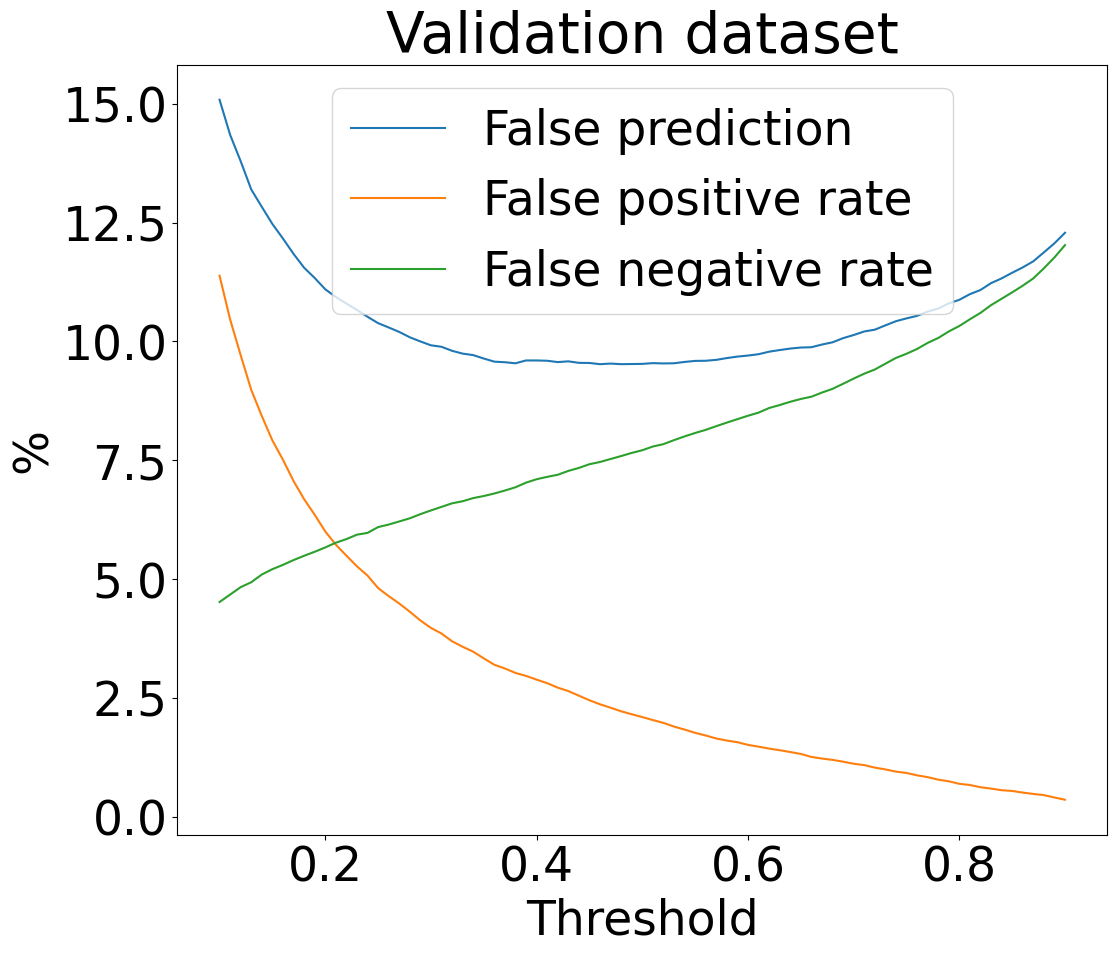

In [34]:
plt.figure(figsize=(12,10))
plt.plot(threshold,res_threshold[:,0]*100,label='False prediction')
plt.plot(threshold,res_threshold[:,1]*100,label='False positive rate')
plt.plot(threshold,res_threshold[:,2]*100,label='False negative rate')
#plt.plot(threshold,res_threshold[:,3]*100,label='Average accuracy')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('%')
plt.title('Validation dataset')
name_fig= PATH+ 'threshold_accuracy_cnn'+name_fig_sup
#plt.savefig(name_fig)

In [35]:
# choose threshold to give a FPR close to expected value
ind=np.argmin((res_threshold[:,1]-FPR)**2)
threshold_FPR=threshold[ind]


In [36]:
# different threshold for each radionuclide
# give the best accuracy for each radionuclide
threshold=np.linspace(0.1,0.9,81)
threshold_test_ind_multi=[]
y_true=y_true_val
for j in range(len(threshold)):
    y_pred=1*(y_pred_val>=threshold[j])
    cf_matrix = multilabel_confusion_matrix(y_true, y_pred)
    threshold_test_ind_multi+=[[cf_matrix[:,0,1],cf_matrix[:,1,0],cf_matrix[:,0,1]+cf_matrix[:,1,0]]]
threshold_test_ind_multi=np.array(threshold_test_ind_multi)
threshold_test_ind_multi=threshold_test_ind_multi/len(y_true)
# index give the best accuracy for each radionuclide
index_best_multi=np.argmin(threshold_test_ind_multi[:,2,:],0)


### Test dataset

In [37]:
y_pred_cnn_raw=trainer.predict(model_multi, dataloaders=test_dataloader2)
y_pred_cnn_raw=[torch.sigmoid(y_pred_cnn_raw[i]).detach().numpy() for i in range(len(y_pred_cnn_raw))]
y_pred_cnn_raw=np.concatenate(y_pred_cnn_raw,0)
if (variability==False) and (drift==False): 
    y_true_test=(data_test[:,1:]>0)*1
else:
    y_true_test=(data_test[:,1:-1]>0)*1


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.34it/s]


In [38]:
# result of CNN which gives a FPR close to expectd value
y_pred_cnn=1*(y_pred_cnn_raw>threshold_FPR)
# result of CNN which gives the best accuracy
threshold_multi_best=(threshold[index_best_multi])*np.ones(len(y_true_test)).reshape(-1,1)
y_pred_cnn_multi_best=1*(y_pred_cnn_raw>=threshold_multi_best)
# choose the case for which you want to show the result 
data_tmp=y_pred_cnn
#data_tmp=y_pred_cnn_multi_best

In [39]:
print('Multi label')
FP_Bkg_index=(np.sum(y_true_test,1)==0)
acc_Bkg=np.all(data_tmp==y_true_test,1)[FP_Bkg_index]*1
#print(f'Fasle positive when source = Bkg: {np.sum(acc_Bkg)/len(acc_Bkg)*100:.2f}')

cf_matrix_cnn = multilabel_confusion_matrix(y_true_test, data_tmp)
all_cf_cnn=np.sum(cf_matrix_cnn,0)
print(f'Accuracy: {(all_cf_cnn[0,0]+all_cf_cnn[1,1])/np.sum(all_cf_cnn)*100:.2f}')

acc_test=np.all(data_tmp==y_true_test,1)*1
print(f'Perfect prediction rate:  {np.sum(acc_test)/len(acc_test)*100:.2f}')

false_cnn=[]
false_pos_cnn=[]
false_nev_cnn=[]

#y_pred=(res_unmixing[3][:,h,1:]>0)*1

for i in range(len(y_true_test)):
    if not (data_tmp[i]==y_true_test[i]).all():
        false_cnn+=[i]
        list_radio_pres=np.arange(len(RN_NAME2))[y_true_test[i]==1]   
               
        tmp=np.arange(len(RN_NAME2))[data_tmp[i]==1]#list radio present estimated
        if all(item in tmp for item in list_radio_pres):
            false_pos_cnn+=[i]
        elif all(item in list_radio_pres for item in tmp):
            false_nev_cnn+=[i]
        else:
            false_nev_cnn+=[i]
            false_pos_cnn+=[i]
print(f'False prediction: {len(false_cnn)/len(test_sce)*100:.2f}')
print(f'False positive rate: {len(false_pos_cnn)/len(test_sce)*100:.2f}')
print(f'False negative rate: {len(false_nev_cnn)/len(test_sce)*100:.2f}')



Multi label
Accuracy: 98.73
Perfect prediction rate:  90.63
False prediction: 9.37
False positive rate: 0.91
False negative rate: 8.67


## Mono label

### Validation data

In [40]:
t1=time.time()
y_pred_val_mono=[]
for i in range(len(RN_NAME2)):
    path_checkpoint=path_checkpoint_mono[i]
    y_pred_val_mono_ind=[]
    model = CNN_Classifier.load_from_checkpoint(path_checkpoint)
    model.eval()
    pred=trainer.predict(model, dataloaders=val_dataloader2)
    pred=[torch.sigmoid(pred[i]).detach().numpy() for i in range(len(pred))]
    pred=np.concatenate(pred,0)
    y_pred_val_mono+=[pred]  
y_pred_val_mono=np.array(y_pred_val_mono)
y_pred_val_mono=y_pred_val_mono.T.squeeze()
print(time.time()-t1)

You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.35it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.37it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.43it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.41it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.44it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.38it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.33it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.42it/s]
81.5114176273346


In [41]:
threshold=np.linspace(0.1,0.9,81)
res_threshold_mono=[]
y_true=y_true_val
for j in range(len(threshold)):
    y_pred=1*(y_pred_val_mono>threshold[j])
    false_cnn=[]
    false_pos_cnn=[]
    false_nev_cnn=[]
    n=len(y_true_val)
    for i in range(n):
        if not (y_pred[i]==y_true[i]).all():
            false_cnn+=[i]
            list_radio_pres=np.arange(len(RN_NAME2))[y_true[i]==1]   
            tmp=np.arange(len(RN_NAME2))[y_pred[i]==1]#list radio present estimated
            if all(item in tmp for item in list_radio_pres):
                false_pos_cnn+=[i]
            elif all(item in list_radio_pres for item in tmp):
                false_nev_cnn+=[i]
            else:
                false_nev_cnn+=[i]
                false_pos_cnn+=[i]
    cf_matrix = multilabel_confusion_matrix(y_true, y_pred)
    all_cf=np.sum(cf_matrix,0)
    res_threshold_mono+=[[len(false_cnn)/n,len(false_pos_cnn)/n,len(false_nev_cnn)/n,(all_cf[0,0]+all_cf[1,1])/np.sum(all_cf)]]
res_threshold_mono=np.array(res_threshold_mono)

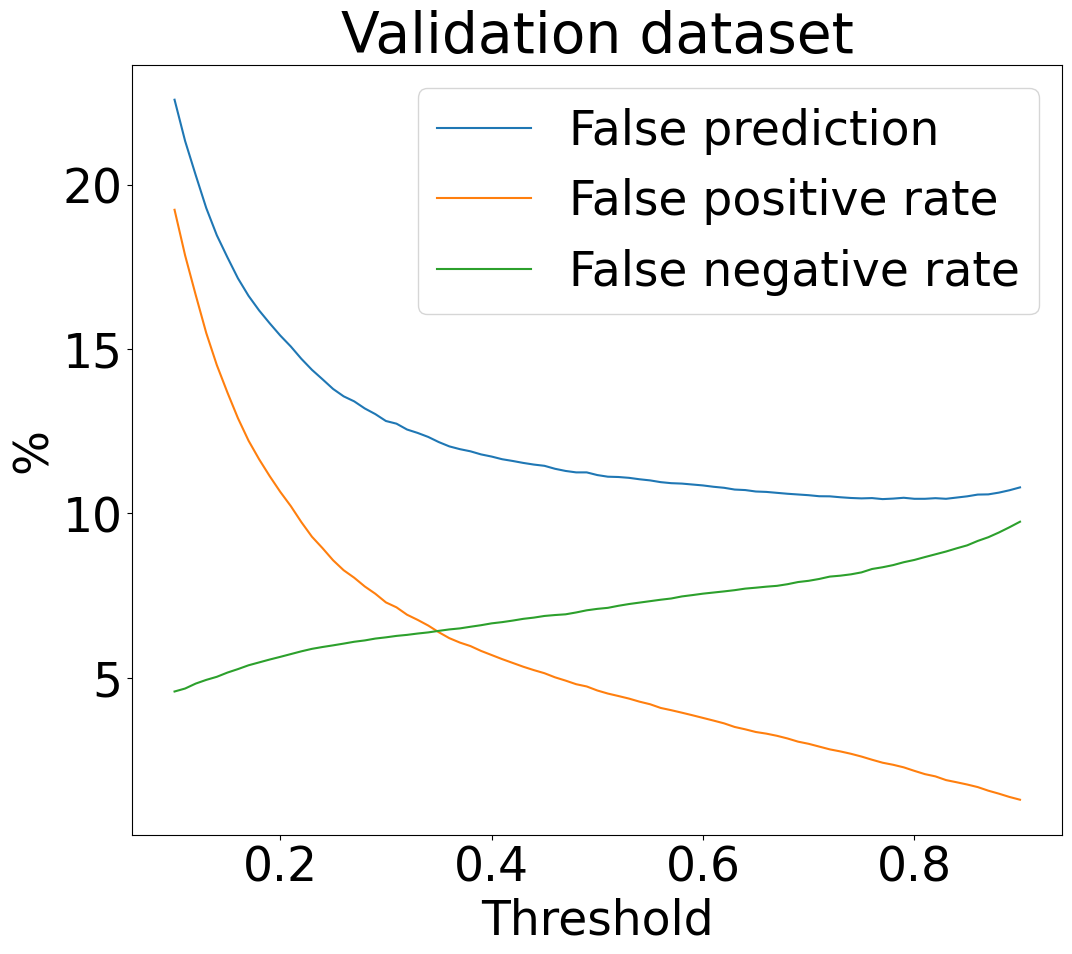

In [42]:
plt.figure(figsize=(12,10))
plt.plot(threshold,res_threshold_mono[:,0]*100,label='False prediction')
plt.plot(threshold,res_threshold_mono[:,1]*100,label='False positive rate')
plt.plot(threshold,res_threshold_mono[:,2]*100,label='False negative rate')
#plt.plot(threshold,res_threshold[:,3]*100,label='Average accuracy')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('%')
plt.title('Validation dataset')
ylim=plt.gca().get_ylim()
#plt.plot(best_threshold_mono*np.ones(100),np.linspace(ylim[0],ylim[1],100),'--')
name_fig= PATH+ 'threshold_accuracy_cnn_mono'+name_fig_sup

#plt.savefig(name_fig)

In [43]:
## choose threshold to give a FPR close to expected value
ind=np.argmin((res_threshold_mono[:,1]-FPR)**2)
threshold_FPR_indiv=threshold[ind]

In [44]:
# different threshold for each radionuclide
# give the best accuracy for each radionuclide
threshold_mono=np.linspace(0.1,0.9,81)
res_threshold_test_mono_ind=[]
y_true=y_true_val
for j in range(len(threshold_mono)):
    y_pred=1*(y_pred_val_mono>=threshold_mono[j])
    cf_matrix = multilabel_confusion_matrix(y_true, y_pred)
    res_threshold_test_mono_ind+=[[cf_matrix[:,0,1],cf_matrix[:,1,0],cf_matrix[:,0,1]+cf_matrix[:,1,0]]]
res_threshold_test_mono_ind=np.array(res_threshold_test_mono_ind)
res_threshold_test_mono_ind=res_threshold_test_mono_ind/len(y_true_val)
# index give the best accuracy for each radionuclide
index_best_mono=np.argmin(res_threshold_test_mono_ind[:,2,:],0)

### Test data

In [45]:
t1=time.time()
y_pred_test_mono=[]
for i in range(len(RN_NAME2)):
    path_checkpoint=path_checkpoint_mono[i]
    y_pred_test_mono_ind=[]
    model = CNN_Classifier.load_from_checkpoint(path_checkpoint)
    model.eval()
    pred=trainer.predict(model, dataloaders=test_dataloader2)
    pred=[torch.sigmoid(pred[i]).detach().numpy() for i in range(len(pred))]
    pred=np.concatenate(pred,0)
    y_pred_test_mono+=[pred]
y_pred_test_mono=np.array(y_pred_test_mono)
y_pred_test_mono=y_pred_test_mono.T.squeeze()
print(time.time()-t1)

You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\DP272459\Anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.36it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.55it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.49it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.45it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.43it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.45it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.46it/s]


You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████| 79/79 [00:10<00:00,  7.50it/s]
97.81889414787292


### Result

In [46]:
# result of CNN which gives a FPR close to expectd value
y_pred_cnn_mono=1*(y_pred_test_mono>threshold_FPR_indiv)
# result of CNN which gives the best accuracy
threshold_mono_best=(threshold_mono[index_best_mono])*np.ones(len(y_true_test)).reshape(-1,1)
y_pred_cnn_mono_best=1*(y_pred_test_mono>=threshold_mono_best)
# choose the case for which you want to show the result 
data_tmp=y_pred_cnn_mono
#data_tmp=y_pred_cnn_mono_best


In [47]:


cf_matrix_cnn_mono = multilabel_confusion_matrix(y_true_test, data_tmp)
all_cf_cnn_mono=np.sum(cf_matrix_cnn_mono,0)
print(f'Accuracy: {(all_cf_cnn_mono[0,0]+all_cf_cnn_mono[1,1])/np.sum(all_cf_cnn_mono)*100:.2f}')

acc_test_mono=np.all(data_tmp==y_true_test,1)*1
print(f'Perfect prediction rate:  {np.sum(acc_test_mono)/len(acc_test_mono)*100:.2f}')


false_cnn_mono=[]
false_pos_cnn_mono=[]
false_nev_cnn_mono=[]

for i in range(len(y_true_test)):
    if not (data_tmp[i]==y_true_test[i]).all():
        false_cnn_mono+=[i]
        list_radio_pres=np.arange(len(RN_NAME2))[y_true_test[i]==1]   
               
        tmp=np.arange(len(RN_NAME2))[data_tmp[i]==1]#list radio present estimated
        if all(item in tmp for item in list_radio_pres):
            false_pos_cnn_mono+=[i]
        elif all(item in list_radio_pres for item in tmp):
            false_nev_cnn_mono+=[i]
        else:
            false_nev_cnn_mono+=[i]
            false_pos_cnn_mono+=[i]
print(f'False prediction: {len(false_cnn_mono)/len(test_sce)*100:.2f}')
print(f'False positive rate: {len(false_pos_cnn_mono)/len(test_sce)*100:.2f}')
print(f'False negative rate: {len(false_nev_cnn_mono)/len(test_sce)*100:.2f}')



Accuracy: 98.66
Perfect prediction rate:  90.15
False prediction: 9.85
False positive rate: 1.15
False negative rate: 8.86


# Result of statistical approach

In [48]:
with open(path_res_unmmixing, "rb") as fp:   #Pickling
    res_unmixing=pickle.load(fp)

In [49]:
h=2
y_pred_unmixing=(res_unmixing[-1][:,h,1:]>0)*1
tmp2=res_unmixing[-1][:,h,1:].copy()
### for variability and drift, false positive at high stat due to error when estimating X -> constraints
### counting of each identified radionuclide at least 1% of all radio counting (without Bkg) 
### Based on the data
if (variability==True) or (drift==True):
    threshold2=0.01
    counting_threshold=np.sum(tmp2[:,1:len(RN_NAME2)],1).reshape(-1,1).dot(np.ones((1,len(RN_NAME2))))
    # < alpha% of all counting
    tmp2*= (tmp2>counting_threshold*threshold2)
## for drift, Bkg signature is also estimated , more false positives -> add a additional constraint
### estimated counting > min counting- 3*std, 
if drift==True:
    min_counting_radio=np.array([100,50,50,100,100,50,50,50,50])
    min_counting_radio=min_counting_radio-np.sqrt(min_counting_radio)*3
    counting_threshold=np.dot(np.ones((len(y_pred_unmixing),1)),min_counting_radio.reshape((1,-1)))
    tmp2*=(tmp2>=counting_threshold)
    
    
y_pred_unmixing=(tmp2[:,:]>0)*1

print('Unmixing')
cf_matrix_unmixing=multilabel_confusion_matrix(y_true_test,y_pred_unmixing)
all_cf_unmixing=np.sum(cf_matrix_unmixing,0)
print(f'Accuracy: {(all_cf_unmixing[0,0]+all_cf_unmixing[1,1])/np.sum(all_cf_unmixing)*100:.2f}')
acc_test=np.all(y_pred_unmixing==y_true_test,1)*1
print(f'Perfect prediction rate:  {np.sum(acc_test)/len(acc_test)*100:.2f}')

false_unmixing=[]
false_pos_unmixing=[]
false_nev_unmixing=[]


for i in range(len(test_sce)):
    if not (y_pred_unmixing[i]==y_true_test[i]).all():
        false_unmixing+=[i]
        list_radio_pres=np.arange(len(RN_NAME2))[y_true_test[i]==1]   
               
        tmp=np.arange(len(RN_NAME2))[y_pred_unmixing[i]==1]#list radio present estimated
        if all(item in tmp for item in list_radio_pres):
            false_pos_unmixing+=[i]
        elif all(item in list_radio_pres for item in tmp):
            false_nev_unmixing+=[i]
        else:
            false_nev_unmixing+=[i]
            false_pos_unmixing+=[i]
            
print(f'False prediction Unmixing: {len(false_unmixing)/len(test_sce)*100:.2f}')
print(f'False positive Unmixing: {len(false_pos_unmixing)/len(test_sce)*100:.2f}')
print(f'False negative Unmixing: {len(false_nev_unmixing)/len(test_sce)*100:.2f}')



Unmixing
Accuracy: 99.12
Perfect prediction rate:  93.55
False prediction Unmixing: 6.45
False positive Unmixing: 0.89
False negative Unmixing: 5.70


# Comparaison

## Calculate false positive rate and false negative rate

In [50]:
list_res=[y_pred_cnn,y_pred_cnn_mono,y_pred_unmixing]
list_name_plot=['CNN multi','CNN mono','Unmixing']
res_false=[]
for j in range((len(list_res))):
    tmp_res=list_res[j]
    false_pred=np.zeros((len(test_sce),3))

    for i in range(len(test_sce)):
        if not (tmp_res[i]==y_true_test[i]).all():
            false_pred[i,0]=1
            list_radio_pres=np.arange(len(RN_NAME2))[y_true_test[i]==1]   

            tmp=np.arange(len(RN_NAME2))[tmp_res[i]==1]#list radio present estimated
            if all(item in tmp for item in list_radio_pres):
                false_pred[i,1]=1
            elif all(item in list_radio_pres for item in tmp):
                false_pred[i,2]=1
            else:
                false_pred[i,2]=1
                false_pred[i,1]=1
    res_false+=[false_pred]
res_false=np.array(res_false)

In [51]:
df=[]
for i in range(len(list_res)):
    cf_matrix_unmixing=multilabel_confusion_matrix(y_true_test,list_res[i])
    all_cf_unmixing=np.sum(cf_matrix_unmixing,0)
    df+=[(all_cf_unmixing[0,0]+all_cf_unmixing[1,1])/np.sum(all_cf_unmixing)*100]
df=np.round(np.array(df),2).reshape(1,-1)

df2=np.round(np.sum(res_false,1)/len(test_sce)*100,2).T
df2=np.concatenate((100-df2[0:1,:],df2))
df=np.concatenate((df,df2))
df=pd.DataFrame(df.T,index=list_name_plot,columns=['Accuray','PPR','FPrR','FPR','FNR'])
df
#print(df.to_latex(escape = False))

,Accuray,PPR,FPrR,FPR,FNR
CNN multi,98.73,90.63,9.37,0.91,8.67
CNN mono,98.66,90.15,9.85,1.15,8.86
Unmixing,99.12,93.55,6.45,0.89,5.70


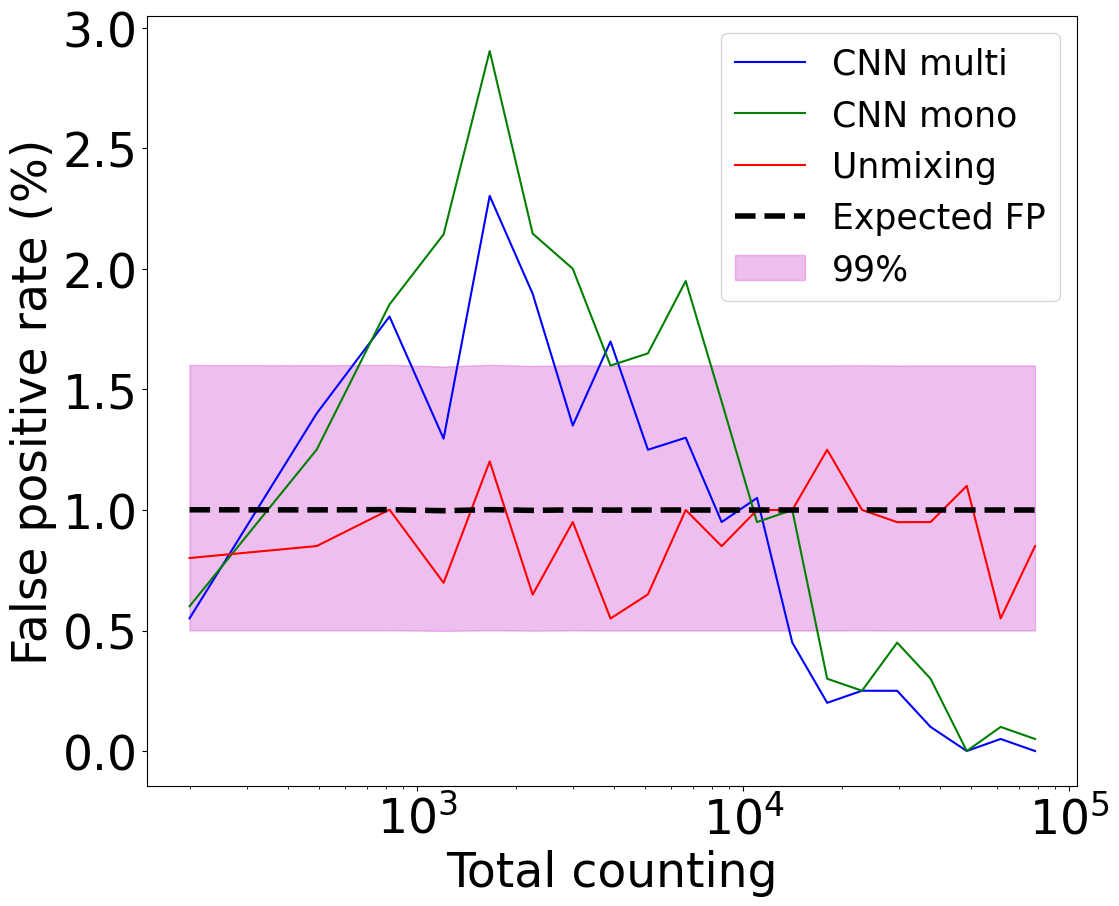

In [52]:
plt.figure(figsize=(12,10))
nbr_plot=[0,1,2]
if (drift==False) and (variability==False): # X knwon
    count_radio=np.sum(test_sce[:,:],1)
else:
    count_radio=np.sum(test_sce[:,:-1],1)
sort_list=np.sort(count_radio)
bins=sort_list[np.arange(20)*np.int_(len(sort_list)/20)] # create histogram with 20 bins
bins=np.append(bins,np.max(sort_list))
hist1=np.histogram(count_radio,bins=bins)

# calculate uncertainty from binomial distribution B(n,p)
n=len(test_sce)
p=0.01
list_band=[]
for i in range(len( hist1[0])):
    list_band+=[np.ceil(scipy.special.bdtrik([0.005, 0.5, 0.995], hist1[0][i], p))/hist1[0][i]*100]
list_band=np.array(list_band)

for j in nbr_plot:
    hist2=np.histogram(count_radio[res_false[j][:,1]==1],bins=bins)
    plt.plot(hist1[1][:-1],(hist2[0]/hist1[0])*100,label=list_name_plot[j],color=list_color[j])
    plt.xscale('log')
plt.plot(hist1[1][:-1],list_band[:,1],'--',color='black',lw=4,label='Expected FP')
plt.fill_between(hist1[1][:-1], list_band[:,0], list_band[:,2], alpha=0.25,label='99%',color='m')
plt.legend(fontsize=25)
plt.ylabel('False positive rate (%)')
plt.xlabel('Total counting')
name_fig= PATH+ 'false_pos_counting'+name_fig_sup
#plt.savefig(name_fig)

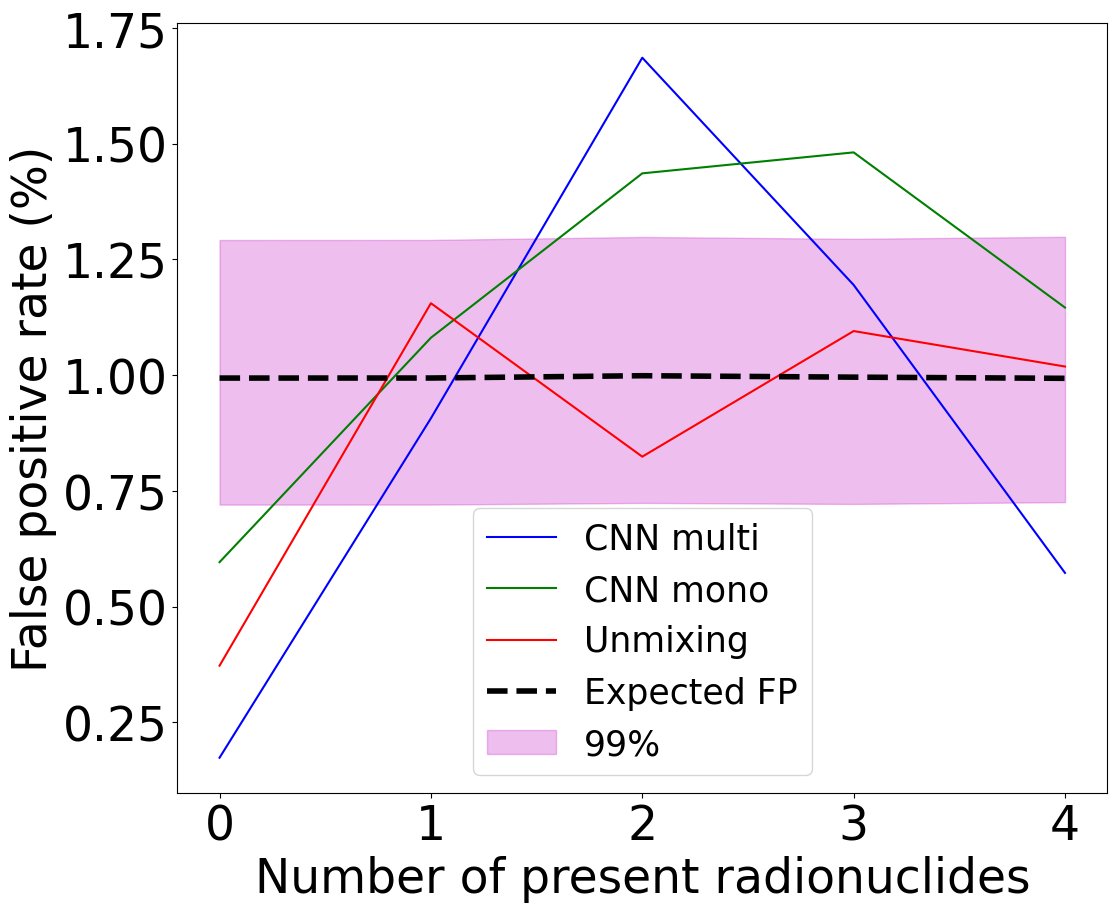

In [53]:
plt.figure(figsize=(12,10))
list_name_plot=['CNN multi','CNN mono','Unmixing']
nbr_plot=[0,1,2]
# number of active radios
if (drift==False) and (variability==False): # X knwon
    nb_radio_active=np.sum(test_sce[:,:]>0,1)
else:
    nb_radio_active=np.sum(test_sce[:,:-1]>0,1)
bins=np.unique(nb_radio_active)    
bins=np.append(np.array([0]),bins)
nb_radio_active=nb_radio_active-1/2
hist1=np.histogram(nb_radio_active,bins=bins)

# calculate uncertainty from binomial distribution B(n,p)
n=len(test_sce)
p=0.01
list_band=[]
for i in range(len( hist1[0])):
    list_band+=[np.ceil(scipy.special.bdtrik([0.005, 0.5, 0.995], hist1[0][i], p))/hist1[0][i]*100]
list_band=np.array(list_band)

for j in nbr_plot:
    hist2=np.histogram(nb_radio_active[res_false[j][:,1]==1],bins=bins)
    plt.plot(hist1[1][:-1],(hist2[0]/hist1[0])*100,label=list_name_plot[j],color=list_color[j])
    #plt.xscale('log')
plt.plot(hist1[1][:-1],list_band[:,1],'k--',lw=4,label='Expected FP')
plt.fill_between(hist1[1][:-1], list_band[:,0], list_band[:,2], alpha=0.25,label='99%',color='m')
plt.legend(fontsize=25)
plt.ylabel('False positive rate (%)')
plt.xlabel('Number of present radionuclides')
name_fig= PATH+ 'false_pos_nbr_radio'+name_fig_sup
#plt.savefig(name_fig)

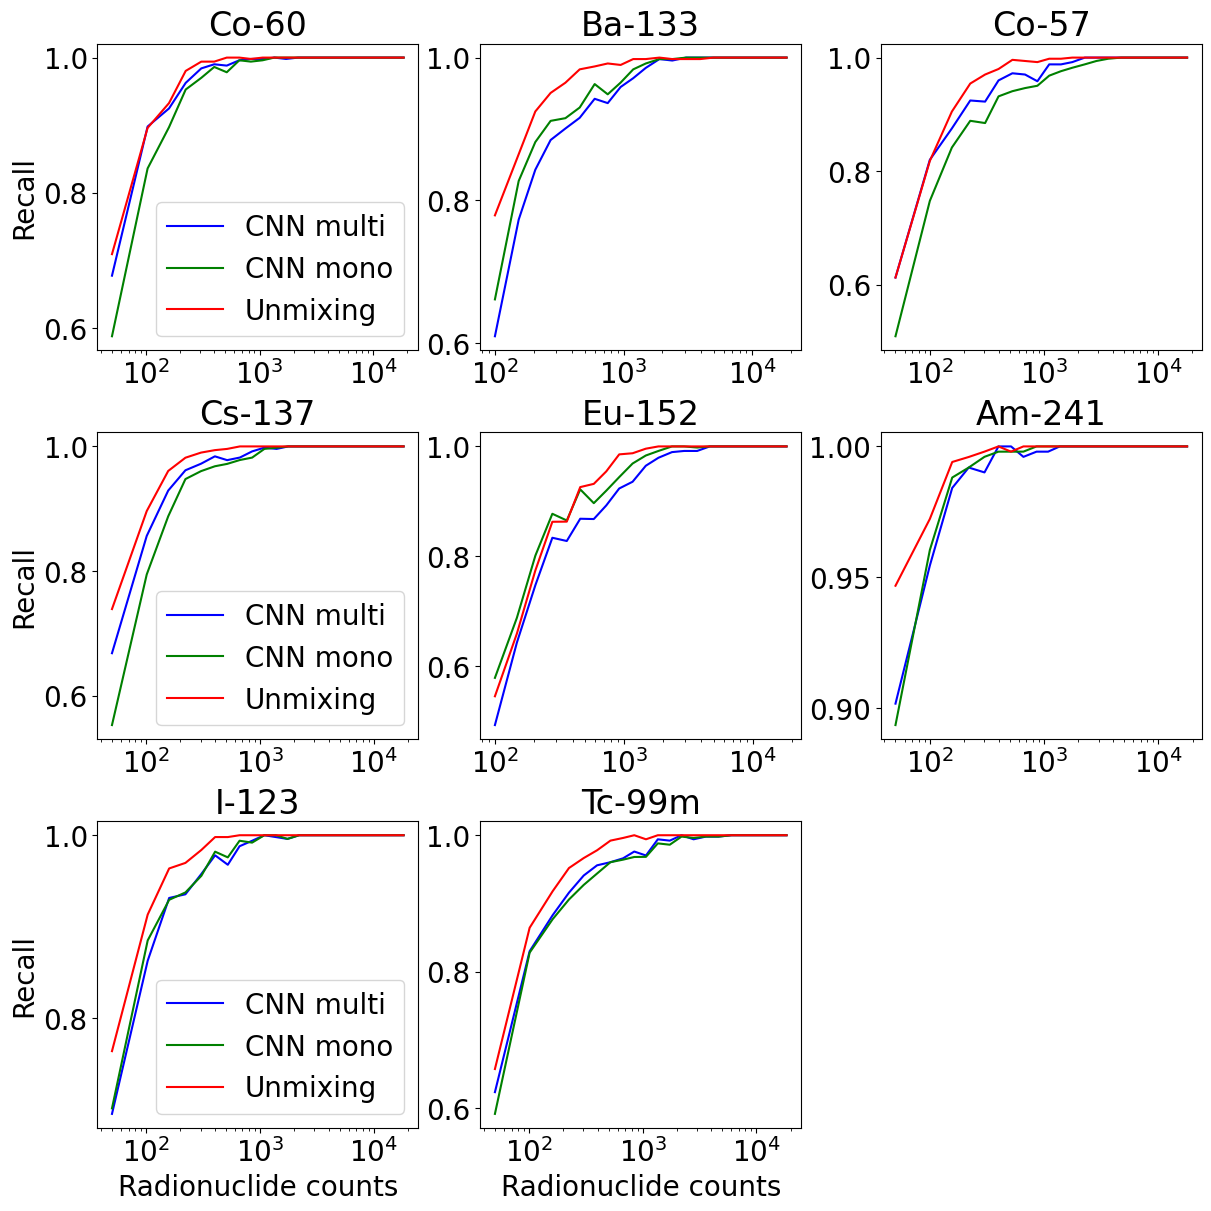

In [54]:
list_res=[y_pred_cnn,y_pred_cnn_mono,y_pred_unmixing]

plt.rcParams.update({'font.size': 20})
nbr_plot=[0,1,2]

fig, axs = plt.subplots(3, 3, figsize=(12, 12),layout="constrained")

for i in range(len(RN_NAME2)):
    ax=axs.flat[i]
    index=test_sce[:,i+1]>0
    count_radio=test_sce[index,i+1]
    
    sort_list=np.sort(count_radio)
    bins=sort_list[np.arange(20)*np.int_(len(sort_list)/20)]
    bins=np.append(bins,np.max(sort_list))
    hist1=np.histogram(count_radio,bins=bins)
    for j in nbr_plot:
        hist2=np.histogram(count_radio[list_res[j][index,i]==1],bins=bins)
        ax.plot(hist1[1][:-1],hist2[0]/hist1[0],label=list_name_plot[j],color=list_color[j])
    ax.set_xscale('log')
    if i>=6:
        ax.set_xlabel('Radionuclide counts')
    if i%3==0:
        ax.set_ylabel('Recall')
        ax.legend()
    ax.set_title(RN_NAME_plot2[i])
if i==7:
    ax=axs.flat[i+1]
    ax.set_visible(False)
    
plt.rcParams.update({'font.size': 34})
name_fig= PATH+ 'false_neg_rate_all2'+name_fig_sup
#plt.savefig(name_fig)

C:\Users\DP272459\AppData\Local\Temp\ipykernel_11256\1428170301.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RN_NAME2,fontsize=20,rotation = 45)


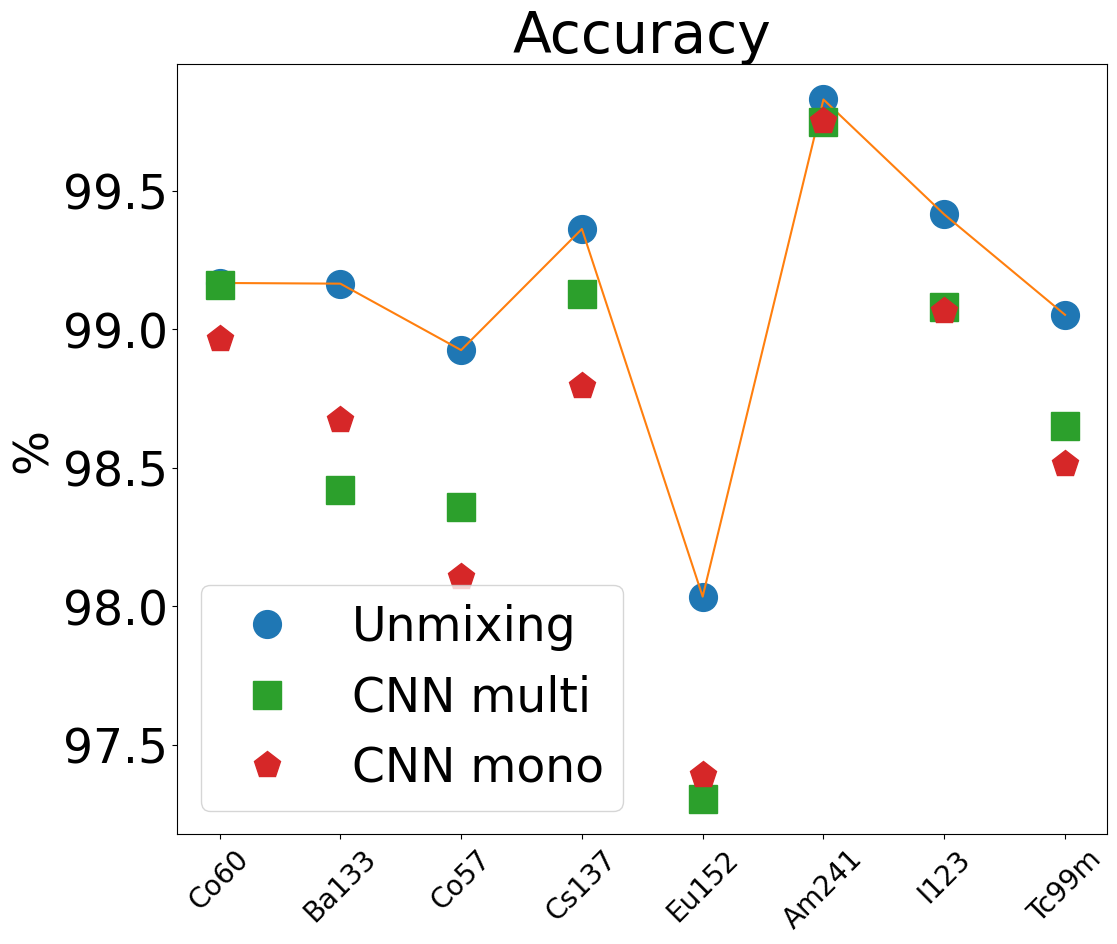

In [55]:
list_pred=[y_pred_unmixing,y_pred_cnn,y_pred_cnn_mono]
list_name_plot=['Unmixing','CNN multi','CNN mono']
marker_list=['o','s','p','*','X']
fig,ax=plt.subplots(1,1,figsize=(12,10))
for i in range(len(list_pred)):
    cf_matrix=multilabel_confusion_matrix(y_true_test,list_pred[i])
    acc=(cf_matrix[:,0,0]+cf_matrix[:,1,1])/len(y_true_test)*100
    ax.plot(np.arange(len(RN_NAME2)),acc,marker_list[i],label=list_name_plot[i],markersize=20)
    if i ==0:
        ax.plot(np.arange(len(RN_NAME2)),acc)

ax.set_xticklabels(RN_NAME2,fontsize=20,rotation = 45)
ax.set_xticks(np.arange(len(RN_NAME2)))
ax.set_ylabel('%')
ax.set_title('Accuracy')
ax.legend()
name_fig= PATH+ 'acc_radio_all'+name_fig_sup
#plt.savefig(name_fig)
    

# Result for thickness (deformation) or  alpha (shift)

### All counting

In [56]:
if (variability==True):
    x_plot=list_thickness
if (drift==True):
    x_plot=list_alpha*100
    
if (variability==True) or (drift==True):
    label_test=test_sce[:,-1]
    list_label_plot=np.unique(label_test)
    list_pred=[y_pred_cnn,y_pred_cnn_mono,y_pred_unmixing]
    list_name_plot=['CNN multi','CNN mono','Unmixing']
    marker_list=['o','s','p','*','X']
    acc_thick=[]
    for i in range(len(list_pred)):
        acc_thick_ind=[]
        for j in list_label_plot:
            tmp=res_false[i,test_sce[:,-1]==j,:]
            tmp=np.sum(tmp,0)/len(tmp)*100
            acc_thick_ind+=[tmp]
        acc_thick+=[acc_thick_ind]
    acc_thick=np.array(acc_thick)
    # calculate uncertainty
    n=len(test_sce)
    n_label_test=np.array([np.sum(test_sce[:,-1]==j) for j in list_label_plot ])
    p=0.01
    list_band=[]
    for i in range(len(list_label_plot)):
        list_band+=[np.ceil(scipy.special.bdtrik([0.005, 0.5, 0.995], n_label_test[i], p))/n_label_test[i]*100]
    list_band=np.array(list_band)

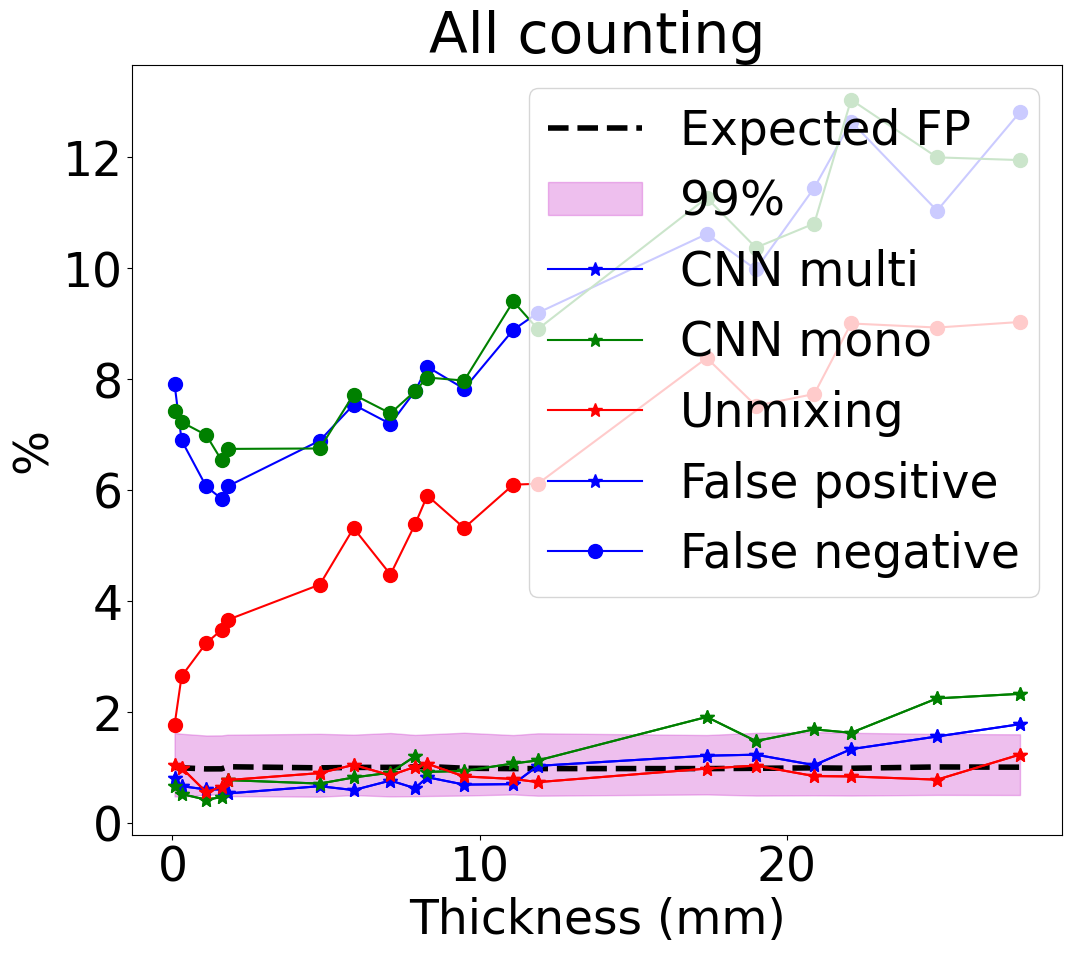

In [57]:
if (variability==True) or (drift==True):
    fig,ax=plt.subplots(1,1,figsize=(12,10))
    ax.plot(x_plot[list_label_plot],list_band[:,1],'k--',lw=4,label='Expected FP')
    ax.fill_between(x_plot[list_label_plot], list_band[:,0], list_band[:,2], alpha=0.25,label='99%',color='m')
    ax.legend()
    for i in nbr_plot:
        ax.plot(x_plot[list_label_plot],acc_thick[i,:,1],marker='*',color=list_color[i],label=list_name_plot[i],markersize=10)
        ax.legend()

    for i in nbr_plot:
        ax.plot(x_plot[list_label_plot],acc_thick[i,:,1],marker='*',color=list_color[i],label='False positive',markersize=10)
        ax.plot(x_plot[list_label_plot],acc_thick[i,:,2],marker='o',color=list_color[i],label='False negative',markersize=10)
        if i==0:
            ax.legend()
    #ax.set_xticklabels(RN_NAME2,fontsize=20,rotation = 45)
    #ax.set_xticks(np.arange(8))
    if (variability==True):
        ax.set_xlabel('Thickness (mm)')
    else:
        ax.set_xlabel('Gain shift (%)')
    ax.set_ylabel('%')
    ax.set_title('All counting')
    #ax.legend()
    name_fig= PATH+ 'acc_thick'+name_fig_sup
    #plt.savefig(name_fig)

### Low, Medium, high stat

In [58]:
if (variability==True) or (drift==True):

    count_radio=np.sum(test_sce[:,:-1],1)
    sort_list=np.sort(count_radio)
    bins=sort_list[np.arange(3)*np.int_(len(sort_list)/3)]# 3 counting level
    bins=np.append(bins,np.max(sort_list))
    hist1=np.histogram(count_radio,bins=bins)
    n=len(test_sce)
    acc_thick_counting=[]
    list_n_counting_thick=np.zeros((3,len(list_label_plot)))# n for counting and thickness
    for k in range(len(bins)-1):
        index=np.arange(n)[(count_radio >=bins[k])*(count_radio <=bins[k+1])]
        acc_thick_tmp=[]
        for i in range(len(list_pred)):
            acc_thick_ind=[]
            for j in range(len(list_label_plot)):
                index2=np.arange(n)[test_sce[:,-1]==list_label_plot[j]]
                #intersection between two lists: same counting level and thickness (alpha)
                index_final=np.sort(np.array(list((set(index) & set(index2)))))
                tmp=res_false[i,index_final,:]
                list_n_counting_thick[k,j]=len(tmp)
                tmp=np.sum(tmp,0)/len(tmp)*100
                acc_thick_ind+=[tmp]
            acc_thick_tmp+=[acc_thick_ind]
        acc_thick_counting+=[acc_thick_tmp]
    acc_thick_counting=np.array(acc_thick_counting)
    #### uncertainty of FPR
    n_thickness_test=np.array([np.sum(test_sce[:,-1]==j) for j in list_label_plot ])
    p=0.01
    list_band_counting= np.zeros((len(bins)-1,len(list_label_plot),3)) # 3: min, mean ,max
    for i in range(list_n_counting_thick.shape[0]):
        for j in range(list_n_counting_thick.shape[1]):
            list_band_counting[i,j,:]=scipy.special.bdtrik([0.005, 0.5, 0.995], 
                                                           list_n_counting_thick[i,j], p)/list_n_counting_thick[i,j]*100
        

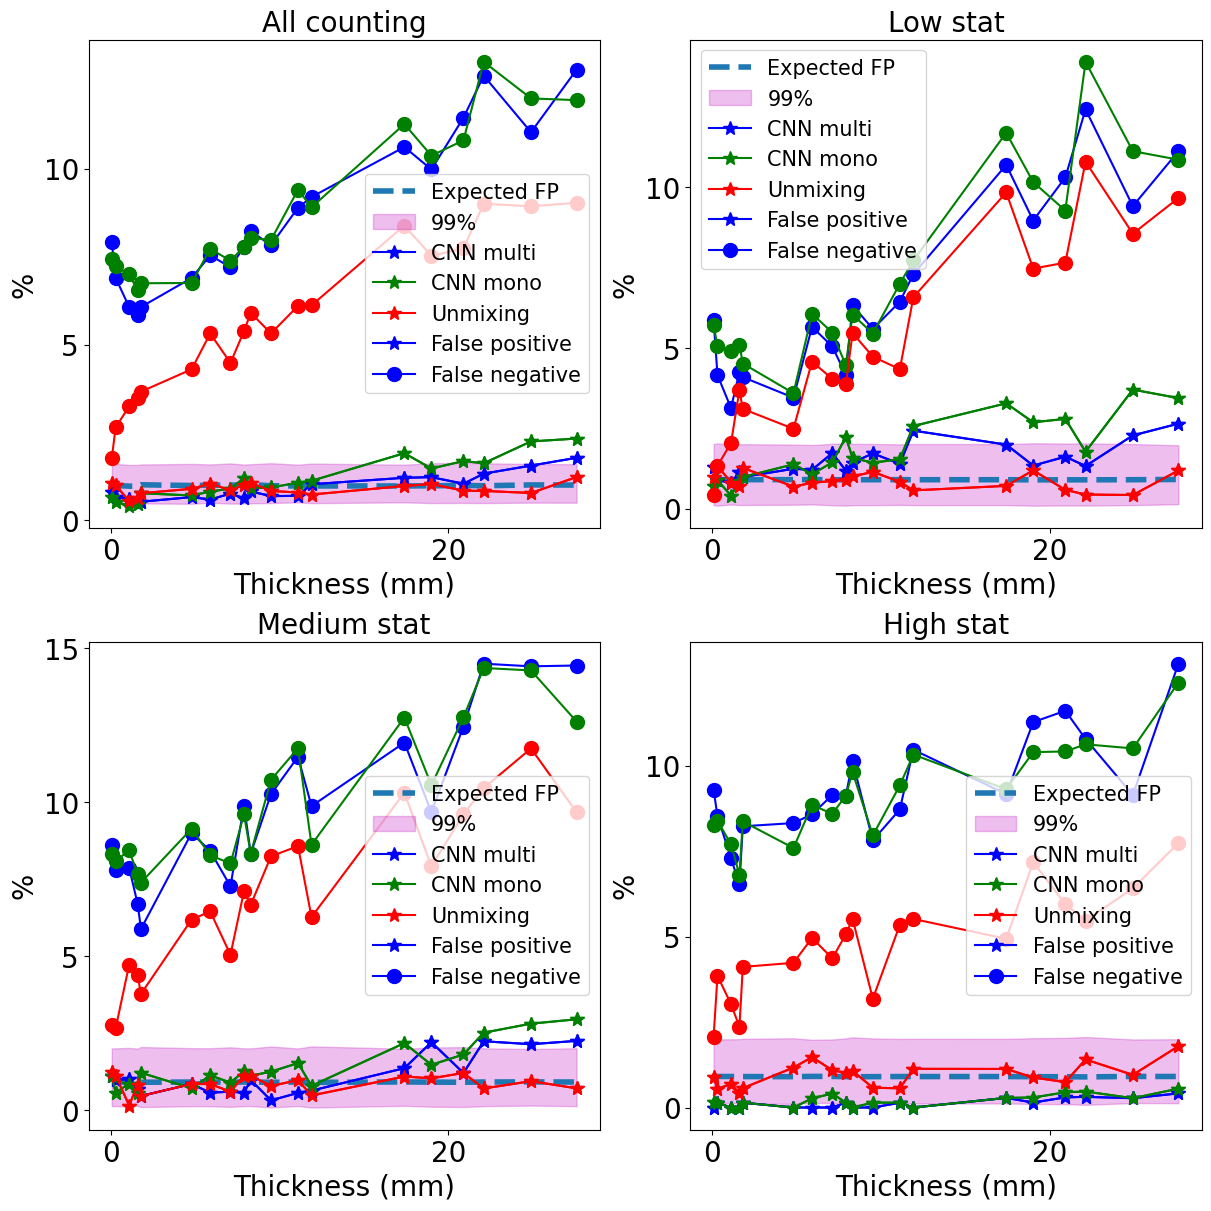

In [59]:
if (variability==True) or (drift==True):
    nbr_plot=[0,1,2]
    plt.rcParams.update({'font.size': 20})
    list_plot_title=['All counting','Low stat','Medium stat','High stat']
    fig,axs=plt.subplots(2,2,figsize=(12,12),layout="constrained")
    for k in range(len(axs.flat)):
        ax=axs.flat[k]
        if k==0:
            list_band_tmp=list_band
            acc_tmp=acc_thick
        else:
            list_band_tmp=list_band_counting[k-1]
            acc_tmp=acc_thick_counting[k-1]

        ax.plot(x_plot[list_label_plot],list_band_tmp[:,1],'--',lw=4,label='Expected FP')
        ax.fill_between(x_plot[list_label_plot], list_band_tmp[:,0], list_band_tmp[:,2], alpha=0.25,label='99%',color='m')
        for i in nbr_plot:
            ax.plot(x_plot[list_label_plot],acc_tmp[i,:,1],marker='*',color=list_color[i],label=list_name_plot[i],markersize=10)
            ax.legend(fontsize=15)

        for i in nbr_plot:
            ax.plot(x_plot[list_label_plot],acc_tmp[i,:,1],marker='*',color=list_color[i],label='False positive',markersize=10)
            ax.plot(x_plot[list_label_plot],acc_tmp[i,:,2],marker='o',color=list_color[i],label='False negative',markersize=10)
            if i==0:
                ax.legend(fontsize=15)

        ax.set_title(list_plot_title[k],fontsize=20)
        if (variability==True):
            ax.set_xlabel('Thickness (mm)')
        else:
            ax.set_xlabel('Gain shift (%)')
        ax.set_ylabel('%')
    plt.rcParams.update({'font.size': 34})
    name_fig= PATH+ 'acc_thick_all'+name_fig_sup
    #plt.savefig(name_fig)

